In [43]:
#!/usr/bin/python

##############################################################################################################################################################################
# Copyright (c) 2017, Miroslav Stoyanov
#
# This file is part of
# Toolkit for Adaptive Stochastic Modeling And Non-Intrusive ApproximatioN: TASMANIAN
#
# Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions
#    and the following disclaimer in the documentation and/or other materials provided with the distribution.
#
# 3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse
#    or promote products derived from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES,
# INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED.
# IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY,
# OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA,
# OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#
# UT-BATTELLE, LLC AND THE UNITED STATES GOVERNMENT MAKE NO REPRESENTATIONS AND DISCLAIM ALL WARRANTIES, BOTH EXPRESSED AND IMPLIED.
# THERE ARE NO EXPRESS OR IMPLIED WARRANTIES OF MERCHANTABILITY OR FITNESS FOR A PARTICULAR PURPOSE, OR THAT THE USE OF THE SOFTWARE WILL NOT INFRINGE ANY PATENT,
# COPYRIGHT, TRADEMARK, OR OTHER PROPRIETARY RIGHTS, OR THAT THE SOFTWARE WILL ACCOMPLISH THE INTENDED RESULTS OR THAT THE SOFTWARE OR ITS USE WILL NOT RESULT IN INJURY OR DAMAGE.
# THE USER ASSUMES RESPONSIBILITY FOR ALL LIABILITIES, PENALTIES, FINES, CLAIMS, CAUSES OF ACTION, AND COSTS AND EXPENSES, CAUSED BY, RESULTING FROM OR ARISING OUT OF,
# IN WHOLE OR IN PART THE USE, STORAGE OR DISPOSAL OF THE SOFTWARE.
##############################################################################################################################################################################
#
#
#  The examples below were adjusted for the OSE 19 lab at BFI Chicago.
#  Simon Scheidegger
#
##############################################################################################################################################################################

# necessary import for every use of TASMANIAN
#
import TasmanianSG
import numpy as np

# imports specifically needed by the examples
import math
from random import uniform
from datetime import datetime

print("TasmanianSG version: {0:s}".format(TasmanianSG.__version__))
print("TasmanianSG license: {0:s}".format(TasmanianSG.__license__))

grid  = TasmanianSG.TasmanianSparseGrid()
grid1 = TasmanianSG.TasmanianSparseGrid()
grid2 = TasmanianSG.TasmanianSparseGrid()

#############################################################################

# EXAMPLE 1 for OSE:
# interpolate: f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
# using piecewise linear basis functions.

# 1000 2-dimensional sample points 
aPnts = np.empty([1000, 2])  
for iI in range(1000):
    for iJ in range(2):
        aPnts[iI][iJ] = uniform(-1.0, 1.0)

# Result
aTres = np.empty([1000,])
for iI in range(1000):
    aTres[iI] = math.cos(0.5 * math.pi * aPnts[iI][0]) * math.cos(0.5 * math.pi * aPnts[iI][1])

# Sparse Grid with dimension 2 and 1 output and refinement level 5
iDim = 2
iOut = 1
iDepth = 5
which_basis = 1 #1= linear basis functions -> Check the manual for other options

print("\n-------------------------------------------------------------------------------------------------")
print("Example 1 for OSE: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)")
print("       using fixed sparse grid with depth {0:1d}".format(iDepth))
print("       the error is estimated as the maximum from 1000 random points\n")

# construct sparse grid
grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
aPoints = grid.getPoints()
iNumP1 = aPoints.shape[0]
aVals = np.empty([aPoints.shape[0], 1])
for iI in range(aPoints.shape[0]):
    aVals[iI] = math.cos(0.5 * math.pi * aPoints[iI][0]) * math.cos(0.5 * math.pi * aPoints[iI][1])
grid.loadNeededPoints(aVals)
# grid.plotPoints2D()
# grid.plotResponse2D()

# compute the error
aRes = grid.evaluateBatch(aPnts)
fError1 = max(np.fabs(aRes[:,0] - aTres))
print(" For localp    Number of points: {0:1d}   Max. Error: {1:1.16e}".format(iNumP1, fError1))

# write coordinates of grid to a text file
f=open("fix_sparse_grid.txt", 'a')
np.savetxt(f, aPoints, fmt='% 2.16f')
f.close()

#############################################################################

## EXAMPLE 2 for OSE:
## interpolate: f(x,y) = exp(-x) / (1 + 100 * exp(-10 * y))
## using refinement

aTres = np.empty([1000,])
for iI in range(1000):
    aTres[iI] = math.cos(0.5 * math.pi * aPnts[iI][0]) * math.cos(0.5 * math.pi * aPnts[iI][1])

# Adaptive Sparse Grid with dimension 2 and 1 output and maximum refinement level 5, refinement criterion.
iDim = 2
iOut = 1
iDepth = 1
fTol = 1.E-5
which_basis = 1 
refinement_level = 5

# level of grid before refinement
grid1.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")

aPoints = grid1.getPoints()
aVals = np.empty([aPoints.shape[0], 1])
for iI in range(aPoints.shape[0]):
    aVals[iI] = math.cos(0.5 * math.pi * aPoints[iI][0]) * math.cos(0.5 * math.pi * aPoints[iI][1])
grid1.loadNeededPoints(aVals)

print("\n-------------------------------------------------------------------------------------------------")
print("Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)")
print("   the error is estimated as the maximum from 1000 random points")
print("   tolerance is set at 1.E-5 and piecewise linear basis functions are used\n")

print("               Classic refinement ")
print(" refinement level         points     error   ")

#refinement level
for iK in range(refinement_level):
    grid1.setSurplusRefinement(fTol, 1, "fds")   #also use fds, or other rules
    aPoints = grid1.getNeededPoints()
    aVals = np.empty([aPoints.shape[0], 1])
    for iI in range(aPoints.shape[0]):
        aVals[iI] = math.cos(0.5 * math.pi * aPoints[iI][0]) * math.cos(0.5 * math.pi * aPoints[iI][1])
    grid1.loadNeededPoints(aVals)
#     grid1.plotPoints2D()
#     grid1.plotResponse2D()
    aRes = grid1.evaluateBatch(aPnts)
    fError1 = max(np.fabs(aRes[:,0] - aTres))

    print(" {0:9d} {1:9d}  {2:1.2e}".format(iK+1, grid1.getNumPoints(), fError1))

# write coordinates of grid to a text file
f2=open("Adaptive_sparse_grid.txt", 'a')
np.savetxt(f2, aPoints, fmt='% 2.16f')
f2.close()
 
grid2 = TasmanianSG.TasmanianSparseGrid()
grid2.makeLocalPolynomialGrid(iDim, iOut, refinement_level+iDepth, which_basis, "localp")
a = grid2.getNumPoints()
 
print("\n-------------------------------------------------------------------------------------------------")
print( "   a fix sparse grid of level ", refinement_level+iDepth, " would consist of " ,a, " points")
print("\n-------------------------------------------------------------------------------------------------\n")    

TasmanianSG version: 4.0
TasmanianSG license: BSD 3-Clause

-------------------------------------------------------------------------------------------------
Example 1 for OSE: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
       using fixed sparse grid with depth 5
       the error is estimated as the maximum from 1000 random points

 For localp    Number of points: 145   Max. Error: 7.7750075756960468e-03

-------------------------------------------------------------------------------------------------
Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
   the error is estimated as the maximum from 1000 random points
   tolerance is set at 1.E-5 and piecewise linear basis functions are used

               Classic refinement 
 refinement level         points     error   
         1         9  3.05e-01
         2        14  2.40e-01
         3        27  2.11e-01
         4        58  2.09e-01
         5       125  1.62e-01

-----------------------------

In [3]:
# necessary import for every use of TASMANIAN
#
import TasmanianSG
import numpy as np

# imports specifically needed by the examples
import math
from random import uniform
from datetime import datetime
from matplotlib import pyplot as plt

In [48]:
# abstraction of the original code

def fix_sparse_grid(func, iDim = 2, iOut = 1, iDepth = 5, which_basis = 1, plot = False):
    '''func is a function that takes two variables'''
    
    # 1000 2-dimensional sample points
    aPnts = np.empty([1000, 2])  
    for iI in range(1000):
        for iJ in range(2):
            aPnts[iI][iJ] = uniform(-1.0, 1.0)
        
    grid  = TasmanianSG.TasmanianSparseGrid()
    grid1 = TasmanianSG.TasmanianSparseGrid()
    grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    grid1.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    aPoints = grid.getPoints()
    iNumP1 = aPoints.shape[0]
    aVals = np.empty([aPoints.shape[0], 1])
    for iI in range(aPoints.shape[0]):
        aVals[iI] = func(aPoints[iI][0], aPoints[iI][1])
#         aVals[iI] = math.cos(0.5 * math.pi * aPoints[iI][0]) * math.cos(0.5 * math.pi * aPoints[iI][1])
    grid.loadNeededPoints(aVals)
    aRes = grid.evaluateBatch(aPnts)
    
    # True results
    aTres = np.empty([1000,])
    for iI in range(1000):
        aTres[iI] = func(aPnts[iI][0], aPnts[iI][1])
    
    fError1 = max(np.fabs(aRes[:,0] - aTres))
    
    if plot == True:
        grid.plotPoints2D()
        grid.plotResponse2D()
    
    return iNumP1, fError1


def adaptive_sparse_grid(func, iDim = 2, iOut = 1, iDepth = 1, fTol = 1.E-5, which_basis = 1,\
                         refinement_level = 5, plot = False):
    grid  = TasmanianSG.TasmanianSparseGrid()
    grid1 = TasmanianSG.TasmanianSparseGrid()
    grid2 = TasmanianSG.TasmanianSparseGrid()
    
    # 1000 2-dimensional sample points
    aPnts = np.empty([1000, 2])  
    for iI in range(1000):
        for iJ in range(2):
            aPnts[iI][iJ] = uniform(-1.0, 1.0)
    
    # level of grid before refinement
    grid1.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")

    aPoints = grid1.getPoints()
    aVals = np.empty([aPoints.shape[0], 1])
    for iI in range(aPoints.shape[0]):
        aVals[iI] = math.cos(0.5 * math.pi * aPoints[iI][0]) * math.cos(0.5 * math.pi * aPoints[iI][1])
    grid1.loadNeededPoints(aVals)
    
    # True results
    aTres = np.empty([1000,])
    for iI in range(1000):
        aTres[iI] = func(aPnts[iI][0], aPnts[iI][1])
    
    # error
        
    iK = refinement_level
    grid1.setSurplusRefinement(fTol, 1, "fds")   #also use fds, or other rules
    aPoints = grid1.getNeededPoints()
    aVals = np.empty([aPoints.shape[0], 1])
    for iI in range(aPoints.shape[0]):
        aVals[iI] = math.cos(0.5 * math.pi * aPoints[iI][0]) * math.cos(0.5 * math.pi * aPoints[iI][1])
    grid1.loadNeededPoints(aVals)
    aRes = grid1.evaluateBatch(aPnts)
    iNums = grid1.getNumPoints()
    fError1 = max(np.fabs(aRes[:,0] - aTres))
    
    if plot == True: # plot got some problems
        grid1.plotPoints2D()
        grid1.plotResponse2D()

    return iNums, fError1

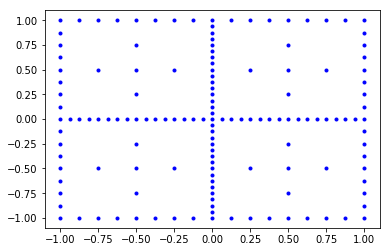

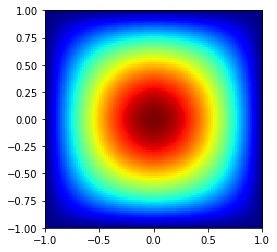

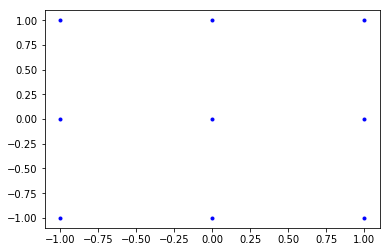

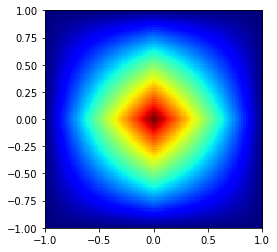

(9, 0.30534804349185657)

In [60]:
func = lambda x, y: math.cos(0.5 * math.pi * x) * math.cos(0.5 * math.pi * y)
fix_sparse_grid(func, iDim = 2, iOut = 1, iDepth = 5, which_basis = 1, plot = True)
adaptive_sparse_grid(func, iDim = 2, iOut = 1, iDepth = 1, fTol = 1.E-5, which_basis = 1,refinement_level = 5, plot = True)

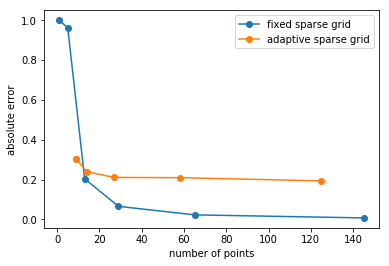

In [47]:
# plot rate of convergence for some function

func = lambda x, y: math.cos(0.5 * math.pi * x) * math.cos(0.5 * math.pi * y)


numberpoints1 = []    
numberpoints2 = []    
abserror1 = []
abserror2 = []
for i in range(6):
    numberpoints1.append(fix_sparse_grid(func, iDepth = i)[0])
    abserror1.append(fix_sparse_grid(func, iDepth = i)[1])
    numberpoints2.append(adaptive_sparse_grid(func, refinement_level = (i-1))[0])
    abserror2.append(adaptive_sparse_grid(func, refinement_level = (i-1))[1])
    
plt.plot(numberpoints1, abserror1, 'o-', label = 'fixed sparse grid')
plt.plot(numberpoints2, abserror2, 'o-', label = 'adaptive sparse grid')
plt.xlabel('number of points')
plt.ylabel('absolute error')
plt.legend()
plt.show()